In [1]:
#Chargement des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, math, random
from pathlib import Path




def load_data_for_correlation(folder):
     """
     Charge les .atoms d'une séquence donnée
     """
     ext = [".atoms"]
     selected_files = sorted(
         [
             path.as_posix()
             for path in filter(lambda path: path.suffix in ext,
folder.glob("*"))
         ]
     )

     N_files = len(selected_files)
     Xc, Yc, Tc,Cyclec = [], [], [], []
     for i in range(N_files):
         path = selected_files[i]
         X, Y, T = get_data(path)
         cycle = np.ones(len(X))*(1+i)
         Xc, Yc, Tc,Cyclec = combine(Xc, Yc, Tc,Cyclec, X, Y, T,cycle)
     # Je crée maintenant un dataframe
     data = np.transpose(np.array([Cyclec, Xc, Yc, Tc]))
     df = pd.DataFrame(data, columns=['Cycle', 'X', 'Y', 'T'])
     return N_files, df

def combine(Xc, Yc, Tc,Cyclec, X, Y, T,cycle):
    """
    Combine les positions et temps d'arrivée des atomes plus le cycle
correspondant aux fichier.
    """
    Xc = np.concatenate([Xc, X])
    Yc = np.concatenate([Yc, Y])
    Tc = np.concatenate([Tc, T])
    Cyclec = np.concatenate([Cyclec, cycle])
    return (Xc, Yc, Tc,Cyclec)

def get_data(path):
    v_perp_x = 1.02  # mm/ns
    v_perp_y = 1.13  # mm/ns
    time_resolution = 1.2e-10
    #time_to_pos = 2 * 0.98e-9

    atoms_file = np.fromfile(path, dtype="uint64")

    atoms = atoms_file * time_resolution

    events_list = atoms.reshape(int(len(atoms) / 4), 4).T

    Xmcp = 0.5 * v_perp_x * 1e9 * (events_list[1] - events_list[0])
    Ymcp = 0.5 * v_perp_y * 1e9 * (events_list[3] - events_list[2])

    X = (Xmcp + Ymcp) / np.sqrt(2)
    Y = (Ymcp - Xmcp) / np.sqrt(2)
    T = (events_list[0] + events_list[1] + events_list[2] + events_list[3]) / 4

    T = T * 1e3

    return (X, Y, T)



def plot_time_histo(T):
     fig = plt.figure()
     plt.hist(T, bins=np.linspace(np.min(T), np.max(T), 300),
color="tab:blue")
     plt.xlabel("Verical velocity (mm/s)")
     plt.ylabel("Number of events")
     plt.grid()
     fig.show()
     return




root = "/mnt/manip_E"
day = "2022/04/29"
sequence = "042"
"""
root = "E:"
day = "2022/04/26"
sequence = "024"
"""
folder = Path(f"{root}/{day}/{sequence}")
N_files, data = load_data_for_correlation(folder)
# Je gicle tous les atomes dont les temps d'arrivée son inférieur à 310
data = data[data["T"]>310]



# Exemple d'utilisation de la classe corrélation
La classe utilise 5 packages : 
* numpy
* pandas
* matplotlib.pyplot
* seaborn 
* alive_progress

Pour construire la classe, il faut lui donner deux arguments obligatoires que sont 
* atoms : pandas dataframe de 4 colonnes comportant le numéro de cycle, et les temps et positions d'arrivée des atomes. Les colonnes devront s'appeler "Cycle" ; "X" ; "Y" et "T".
* n_cycles : le nombre de fichiers / cycles.

Dans la première méthode __init__ appelée, plusieurs attributs sont définis. Tous ces attributs peuvent être modifié en les donnant comme argument lors de la construction de la classe. Parmi ces attributs, on retiendra :
* boxes : dictionnaire donnant position et taille des boîtes 1 et 2 pour les corrélations.
        Forme : { "1": {"Vx": {"size": 10, "position": 0},
                        "Vy": {"size": 3, "position": 0},
                        "Vz": {"size": 0.9, "position": 56},   },
                "2": {  "Vx": {"size": 10, "position": 0},
                        "Vy": {"size": 3, "position": 0},
                        "Vz": {"size": 0.9, "position": 80},   },}
* ROI : dictionnaire, Region Of Interest --> définir une ROI adaptée permet de réduire la taille des dataframe utilisés (en mm/s)
        Format : {"Vx": {"max":120, "min":-120}, "Vx:{"max":20, "min":-20}}
* ROD : dictionnaire, Region Of Desinterest,  pour ne sélectionner que les atomes en dehors de la ROD. Même remarque que pour ROI et même format. Cela sera utilie pour les manips type DCE.

* bec_arrival_time : float, temps d'arrivée du condensat en ms

* raman_kick : float, kick raman en mm/s (toutes les vitesses selon Xsont décalé de raman_kick




In [2]:
from correlations import Correlation

In [3]:
n_cycles = N_files
ROI = {"Vz": {"max": 170, "min": 10}}
boxes = {
    "1": {
        "Vx": {"size": 5, "position": 0},
        "Vy": {"size": 5, "position": 0},
        "Vz": {"size": 1, "position": 56},
    },
    "2": {
        "Vx": {"size": 10, "position": 0},
        "Vy": {"size": 10, "position": 0},
        "Vz": {"size":1, "position": 130},
    },
}
corr = Correlation(data, n_cycles, ROI=ROI, boxes=boxes)

Data are loaded


Nous avons donc maintenant un dataframe d'atomes dont nous pouvons regarder la densité par exemple. Ou bien pour calculer des corrélations entre les deux boites. Pour cela, on appelle la méthode compute_correlations() : c'est cette méthode qui va réaliser les corrélation et les stocker dans un dataframe result (qu'on pourra appeler via corr.result). 

Pour l'instant, nous ne calculons que 
* la variance normalisée,
* $g^{(2)}$
* le nombre d'atome dans chaque boite et la population totale.

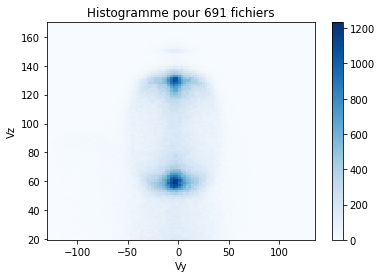

In [71]:
a=corr.show_density()
corr.compute_correlations()
print(corr.result)

## Scanner des corrélations
Bon l'intérêt du programme est de scanner un paramètre, par exemple le centre d'une boîte. Pour cela, il faut définir quelles sont les variables scannées. On a le chiox de définir deux variables (qui sont des objets de la classe variable).
### Objet Variable
Il s'agit d'un objet assez simple dont les attributs permettent de savoir quel boîte nous scannons, on les "crée" en appelant la méthode define_variable et il faut leur définir leur
* box :"1" ou "2" selon que la quantité que l'on scanne concerne la boîte 1 ou 2,
* type : "position" ou "size", selon que ce que l'on veut varier est la taille ou la position de la boîte,
* name : "Vz1" par exemple si on scanne Vz dans la boîte 1. Il faut que le nom des deux paramètres scannés soit différent.
* les valeurs qu'elle vont prendre aka 
    * min, 
    * max 
    * n_step le nombre de valeurs entre min et max.
    on peut aussi leur donner à la place un argument __values__ qui est la liste des valeurs qu'elles doivent prendre.


In [72]:
boxes = {
    "1": {
        "Vx": {"size": 10, "position": 0},
        "Vy": {"size": 10, "position": 0},
        "Vz": {"size": 1, "position": 56},
    },
    "2": {
        "Vx": {"size": 10, "position": 0},
        "Vy": {"size": 10, "position": 0},
        "Vz": {"size":1, "position": 130},
    },
}

corr.boxes = boxes
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=30, max=145, n_step=116
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=30, max=145, n_step=116
)

# corr.show_2D_plot(self, x, y, z="g^2")
corr.compute_correlations()


On a donc maintenant calculé des corrélations et il ne reste plus qu'à afficher les données. 

On peut uitliser la méthode show_2D_plot(args) mais c'est des fois plus pratique de le faire en local.

In [55]:
corr.result

,Vz1,Vz2,N_1,N_2,N_1+N_2,variance,normalized variance,g^2
0,42.0,120.000000,0.041379,0.650000,0.691379,0.989926,1.431813,1.217949
1,42.0,120.182609,0.041379,0.646552,0.687931,0.973422,1.414999,1.224444
2,42.0,120.365217,0.041379,0.663793,0.705172,1.024670,1.453077,1.129870
3,42.0,120.547826,0.041379,0.662069,0.703448,1.090606,1.550372,1.258681
4,42.0,120.730435,0.041379,0.655172,0.696552,1.037051,1.488836,1.526316
...,...,...,...,...,...,...,...,...
13451,75.0,140.269565,0.112069,0.144828,0.256897,0.304099,1.183742,1.699634
13452,75.0,140.452174,0.112069,0.137931,0.250000,0.280366,1.121463,1.896154
13453,75.0,140.634783,0.112069,0.125862,0.237931,0.251534,1.057171,2.200211
13454,75.0,140.817391,0.112069,0.118966,0.231034,0.244780,1.059496,2.069119


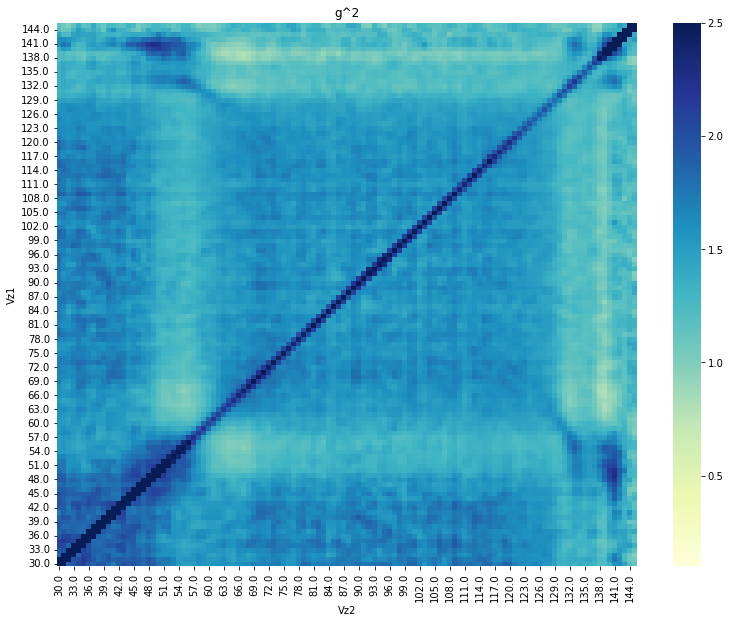

In [73]:
import seaborn as sns

x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.1,
    vmax=2.5,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

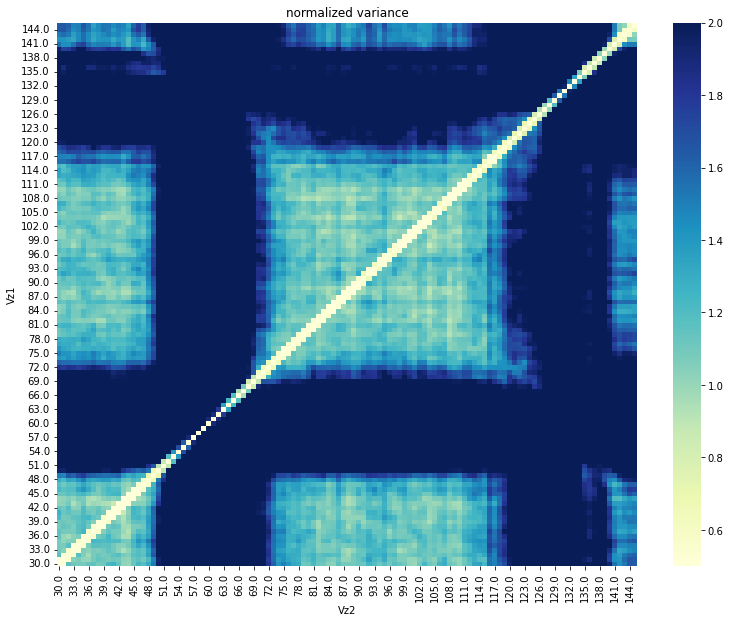

In [74]:
x="Vz1"
y="Vz2"
z="normalized variance"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.5,
    vmax=2,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

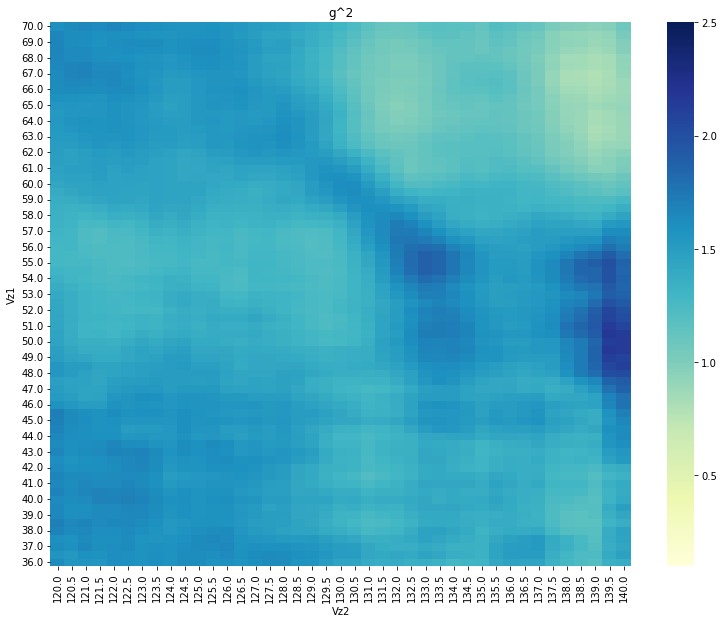

In [77]:
boxes = {
    "1": {
        "Vx": {"size": 10, "position": 0},
        "Vy": {"size": 10, "position": 0},
        "Vz": {"size": 1, "position": 56},
    },
    "2": {
        "Vx": {"size": 10, "position": 0},
        "Vy": {"size": 10, "position": 0},
        "Vz": {"size":1, "position": 130},
    },
}

corr.boxes = boxes
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=36, max=70, n_step=69
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=120, max=140, n_step=41
)

# corr.show_2D_plot(self, x, y, z="g^2")
corr.compute_correlations()
import seaborn as sns

x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.1,
    vmax=2.5,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

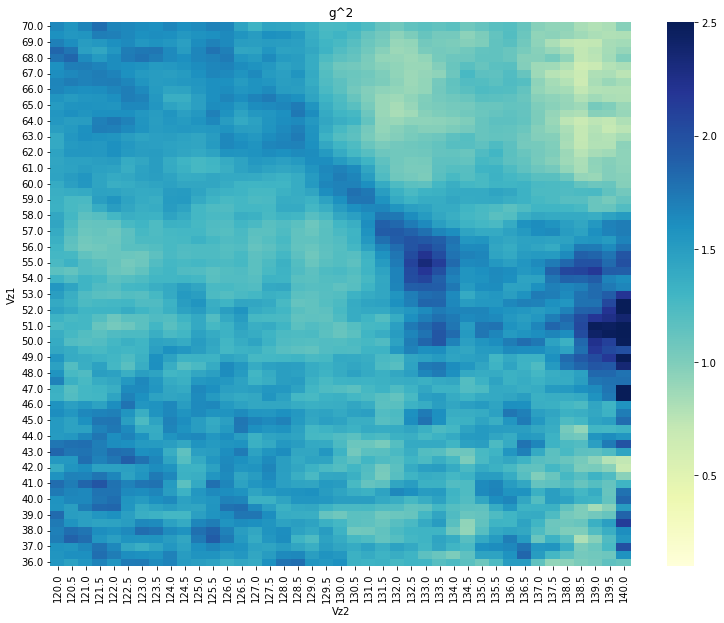

In [81]:
boxes = {
    "1": {
        "Vx": {"size": 7, "position": 0},
        "Vy": {"size": 7, "position": 0},
        "Vz": {"size": 0.5, "position": 56},
    },
    "2": {
        "Vx": {"size": 7, "position": 0},
        "Vy": {"size": 7, "position": 0},
        "Vz": {"size":0.5, "position": 130},
    },
}

corr.boxes = boxes
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=36, max=70, n_step=69
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=120, max=140, n_step=41
)

# corr.show_2D_plot(self, x, y, z="g^2")
corr.compute_correlations()
import seaborn as sns

x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.1,
    vmax=2.5,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

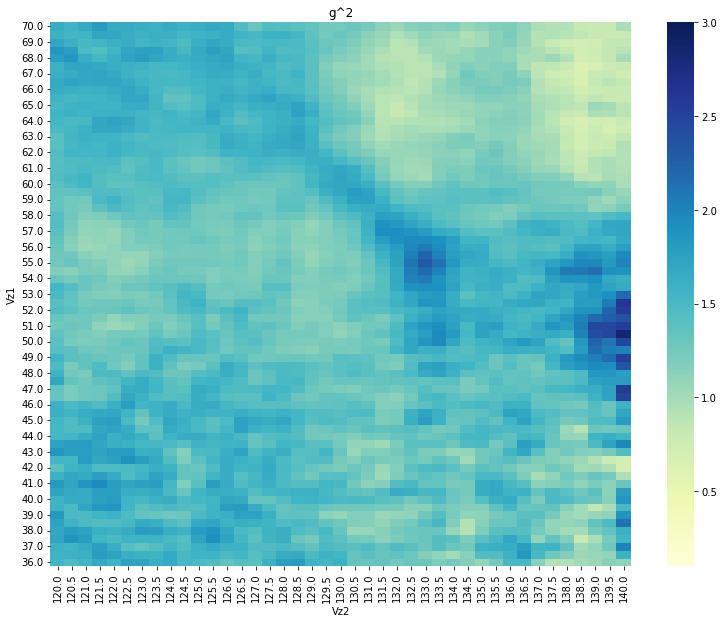

In [82]:
x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.1,
    vmax=3,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

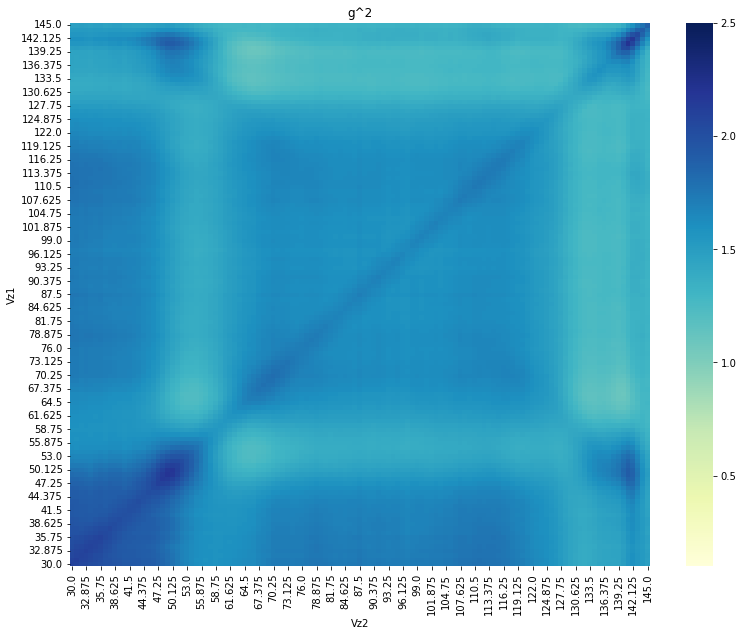

In [83]:
boxes = {
    "1": {
        "Vx": {"size": 32, "position": 0},
        "Vy": {"size": 32, "position": 0},
        "Vz": {"size": 2.8, "position": 56},
    },
    "2": {
        "Vx": {"size": 32, "position": 0},
        "Vy": {"size": 32, "position": 0},
        "Vz": {"size":2.8, "position": 130},
    },
}

corr.boxes = boxes
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=30, max=145, n_step=121
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=30, max=145, n_step=121
)

# corr.show_2D_plot(self, x, y, z="g^2")
corr.compute_correlations()
import seaborn as sns

x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=0.1,
    vmax=2.5,
)
ax.invert_yaxis()
plt.title(z)
plt.show()

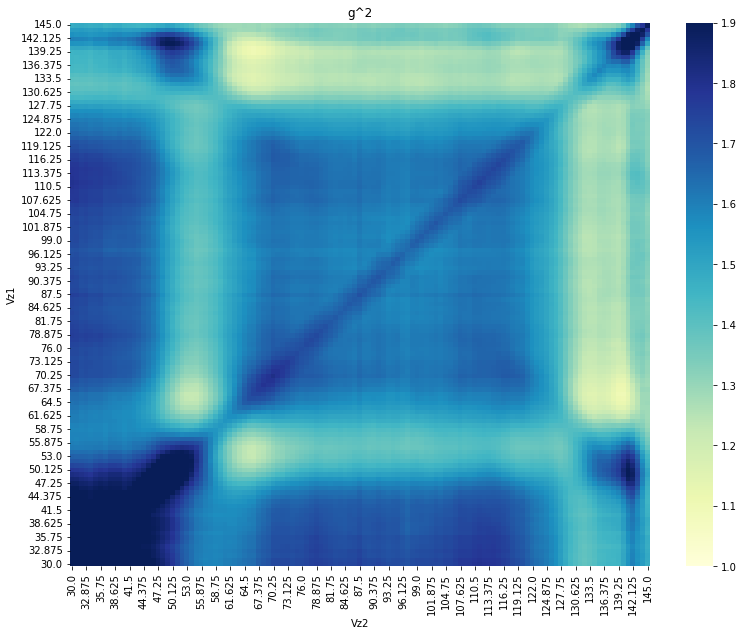

In [88]:

x="Vz1"
y="Vz2"
z="g^2"
df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(
    df_pivoted_correlations,
    cmap="YlGnBu",
    ax=ax,
    vmin=1,
    vmax=1.9,
)
ax.invert_yaxis()
plt.title(z)
plt.show()